# LSTMによる自然言語処理


## テキストデータの前処理

最初に、テキストデータに前処理を行います。


In [2]:
import sys, re, os

# 仕様データ (main)
path_old =  '~'
path_new = '~'


# 前処理
bindata = open(path_old, mode="r", encoding="utf-8")
lines = bindata.readlines()
os.remove(path_new) # 初期化

# 記号削除した方がよい?
for line in lines:
    text = line.strip() # 改行削除
    text = re.sub("《[^》]+》", "", text) # ルビの削除
    text = text.replace('｜','')       # ルビ前記号削除
    text = re.sub("［[^］]+］", "", text) # 読みの注意の削除
    text = re.sub("[｜ 　]", "", text) # | と全角半角スペースの削除
    file = open(path_new, 'a', encoding='utf-8').write(text)  # UTF-8に変換し, 書き込み

# LSTM (idea1)

- 文章を8文字区切りで分割し(maxlen=8), 次の1文字を予測し, それを1文字づつ (step=1)ずらしながら,  データセットを作成する.


## 前処理済みデータの読み込み

In [1]:
# file path
path_new = '~'

with open(path_new, mode="r", encoding="utf-8") as f:  # ファイルの読み込み
    text = f.read()
    print("文字数", len(text))  

文字数 40965


## 準備

1. 出現文字リスト (chars),   index付きの出現文字リスト (char_indices, indices_char)を作成
1. 文章を8文字ずつに分割 (sentences), 8文字で次の1文字を予測する (next_chars)を作成
1. sentences の layer (x), next_chars の layer (y)を作成 ??

In [2]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import matplotlib.pyplot as plt   # 追加
import numpy as np
import random
import io, sys

Using TensorFlow backend.


In [3]:
# ユニークな文字リスト
chars = sorted(list(set(text)))
print('total chars:', len(chars))

# 文字リストのラベルエンコーディング
char_indices = dict((c, i) for i, c in enumerate(chars)) # {index, char}

# 文章の分割
maxlen = 8
step = 1
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen]) # 8文字のinput data
    next_chars.append(text[i + maxlen]) # 1文字のoutput data
print('nb sequences:', len(sentences))

# one hot encoding を利用して, 文字を二値のテンソル配列に格納 
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)  # (40957, 8, 1066)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool) # (40957, 1066)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

total chars: 1066
nb sequences: 40957
Vectorization...


## 学習

1. build a model (要検証)
1. sample function: 
    - 予測にランダム性を組み込むことで, 文章に独自性を与える.
1. on_epoch_end function: 
    - start_index: 文書生成の始点を統一することで変化を見やすくする


In [5]:
# build the model: a single LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))
model.summary()

# model complile
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               611840    
_________________________________________________________________
dense_2 (Dense)              (None, 1066)              137514    
Total params: 749,354
Trainable params: 749,354
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 予測値を確率的にサンプリングする (温度が高いほど, 予測確率の低い文字も採用する)
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    # テキストシードを設定
    start_index = 0   
    # ランダム性 (複数の値を確かめることができる)
    for diversity in [0.3, 0.5, 0.7]: 
        print('----- diversity:', diversity)
        sentence = text[start_index: start_index + maxlen]
        # generated = '"' +  sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(sentence)
 
        for i in range(400):
            # 生成された文章をone-hot encoding化
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.
            # 次の文字を予測
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = chars[next_index]
            # 学習用文章の更新
            sentence = sentence[1:] + next_char
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


# 予測用
def generate_text(model, start_index=0, diversity=0.5, text_len=300):
    # start_index = random.randint(0, len(text) - maxlen - 1)
    print('----- diversity:', diversity)
    sentence = text[start_index: start_index + maxlen]
    generated = sentence
    print('----- Generating with seed: "' + sentence + '"') 
    # 
    for i in range(400):
        # 生成された文章をone-hot encoding化
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.
        # 次の文字を予測
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char = chars[next_index]
        generated += next_char
        # 学習用文章の更新
        sentence = sentence[1:] + next_char
    return generated
    
# Plot Training loss & Validation Loss
def loss_plot(history):
    loss = history.history["loss"]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, "bo", label = "Training loss" )
    plt.title("Training loss")
    plt.legend()
    #plt.savefig("../output/loss.png")
    plt.show()
    plt.close()

In [29]:
# execute    
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(x,y,
                             batch_size=128,
                             epochs=60,
                             callbacks=[print_callback])

Epoch 1/60
40957/40957 [==============================] - 31s 747us/step - loss: 4.1108

----- Generating text after Epoch: 0
----- diversity: 0.3
----- Generating with seed: "若い女性から大人"
若い女性から大人気の香水とはなどです。そのリビドーロゼは、そんなリビドーロゼはそんなり、リビドーロゼはあります。そんな香水です。そしてはリビドーロゼの香水」ということです。そしても、リビドーロゼはあります。そしてはリビドーロゼは女性があります。、そのでリビドーロゼはあります。でした。リビドーロゼはその香水はは、その香水の香水があります。そしてはリビドーロゼは、リビドーロゼはあります。そしてリビドーロゼは、リビドーロゼはあります。でしょう。そんなリビドーロゼはリビドーロゼ」ということです。そしてはリビドーロゼはあります。そんなリビドーロゼはリビドーロゼはあります。それてリビドーロゼは、リビドーロゼはあります。そしてリビドーロゼは、おわからないです。そしてはリビドーロゼはあります。そしてリビドーロゼはあります。でした。リビドーロゼはあります。そしてもリビドーロゼはそのはリビドーロゼは、そのでは、リビドーロゼは
----- diversity: 0.5
----- Generating with seed: "若い女性から大人"
若い女性から大人にフローロンの香水」があります。そしてお少なのでする香水の香水やす。です。ですが、リビドーロゼは購入をする効果に有揮することです。そしてはリビドーロゼ」などがリビドーロゼ」の香水があります。そんでリビドーロゼはあります。そしてもリビドーロゼはその香水をそのでしないです。、そのでaリビドーロゼはなどので、「リビドーロゼが効果があるのです。そしては、そんな香水というというだけので、その香水を自分を使用して香りをするという！！！なんでしょう。そしては、リビドーロゼは、ドラックの香りを見ている商品はリビドーロゼはありません。そしても、リビドーロゼはしいうの効果があります。でした。そのでリビドーロゼはあれません。そした人でした。男性はどのが、その香水が香水などです。そしてリビ

若い女性から大人の女性にリビドーロゼを使用してしまうと、男性は女性の香りがすべたいのではないでしょうか？そこで今回はリビドーロゼを使用して、「香水の香りに気がでさかしたいですよね？？そしてこのリビドーロゼの香りではないて、男性にアピールできるリビドーロゼはどんな商品や人気の香水をつけているのです！！リビドーロゼを使用してしまうと、その香りを気になることができます。したのではないでしょうか？そんなリビドーロゼの先になんか使っている香水です。また、リビドーロゼを使用してしまうと、LCラブコスメの公式が出品しているのですが、以上に大人気の女性がもっとも、気になる人とのデートの時に付けるのがあったのですが、それから、「リビドーロゼ」という香水ではないでしょうか。気になる男性や「なんと、「香水」にリビドーロゼを使用している方ですが、それでも、リビドーロゼを使用してしまうと、男性にアルコールがまなどうことがわかります
----- diversity: 0.7
----- Generating with seed: "若い女性から大人"
若い女性から大人の女性にはないようにしましょう。では、リビドーロゼが手に入るので、注意しましょう。では、男性にその持つが思いまりありつのがいっていました。では、リビドーロゼの公式にはと思っている女性にはなってしまいます。リビドーロゼの公式サイト結事を購入しましょうでしょうから関しても、使うことができます。したい普段は公式サイト大手により、よってしまうのなら、そうしたはジでは、男性の性がの香水ですが、そのリビドーロゼを買ったいをご・・・意中の最のようなもらら、男性によっては「男性がらわれることとして分。なのかが気になることである女性に香水を使用していく方法ですが、それでは、「男性を虜にがある部分は「男性との彼との間にラストのため、そのドラッグスト思まったのですが、その人は気になっている方もいるかもしれません。さらにもちろんですが、リビドーロゼを購入するのではないようなを「得におきる入手が通販ですね。リビドー
Epoch 12/60
40957/40957 [==============================] - 29s 717us/step - loss: 1.2729

----- Generating text after Epoc

若い女性から大人の女性まで大人気ロングセラーの女性用フェロモン香水・リビドーロゼそんな人気の香水を購入ってみるは「男性の本でなの人に子ってい効果をいると、わいが実問い合わせてみる方法がより確実でしょう。と上はらないのです(笑)もちろん、なかなかな？？」と思われた方もようです。いかがいいつもですが、その効果は大きく分けて3。になりましたね(^^)/女性の中には男性側から手を差しましたね(^^)/女性の中には男性側から手を差しましたね。そのリビドーロゼの香りはキイチメルで、気になる部分の悩みはもと言えるでしょう。なので、リビドーロゼを購入する前に、「一度はサンプル(試供品)はもらえるのです。なぜイの目にかとなーてしまいます。では、とてもリビドーロゼを購入する前に、「一度はサンプル(試供品)の入手は不可能ではありませんが、そのしましょう！リビドーロゼを購入する前に、「一度はサンプル(試供品)の入手は不可能ではあ
----- diversity: 0.5
----- Generating with seed: "若い女性から大人"
若い女性から大人の女性まで大人気ロングセラーの女性用フェロモン香水・リビドーロゼそんな人気の香水を購入する前に」と思われると、自分にもと記載されていました。ですがそんなにという女性の悩みはは無くに、男性の本能に香りは楽天や調べたと思います。女性の「リビドーロゼ」を付けた方が近るで、ベッド専用のため使用期限についてですが、その人気のある、セクシャルなエキテチランイランのがする？もし「が付け合かしAmazonなどの香水も試してみよう！」という男性が本当にアな香水でリビドーロゼがよく効く年齢層は10代～40代の女性が多いとは思いますが、その効果は大きく分リビドーロゼを購入する前に、「一度はサンプル(試供品)はリビドーロゼにはフローラルが入っているのです！！そんなリビドーロゼの香りは男性が女性のフェロモンを効果的に感じる香りや匂いではありませんか？女性ならとの女性であるはベット専用フェロモン香水・リビドーロゼリビ
----- diversity: 0.7
----- Generating with seed: "若い女性から大人"
若い女性から大人の女性まで大人気ロングセラーの女性用フェロモン香水・リビドーロゼそんな女性から、より最香その付い香る？っしい

若い女性から大人の女性がほとんどがっているのです。そんなリビドーロゼをつける最大のポイントとしては「どこの彼で約る最考の使いもしろ。ませんだった女性ないのにはする、リビドーロゼ公式はまとめると、つけるるのもあり、その人の気持ちがわからないたや、ストのありませんから、そこで今回は実際に購入した方々の手でもその気にさせる女性をより際は、ためリビドーロゼを、リビドローゼそのリビドーロゼについての効果などを詳しく調べてから購入するのも一つの手かも？？先ほど、リビドーロゼについての効果などを用のたくなるため、まとした恋をなップのに使用したい」というのが女性の本ベ的な大きなみに最対する最はのラッベストアンタイムの時はな使用するおすすめですが、男性はとのっておすすもその用のお気に入したら、そうしたことがあるのではないでしょうか？フェロモン香水が販売されるお女性にベッドでみる以ス」という恋がを女性の秘密アイテム・香水のた
Epoch 33/60
40957/40957 [==============================] - 25s 602us/step - loss: 0.5946

----- Generating text after Epoch: 32
----- diversity: 0.3
----- Generating with seed: "若い女性から大人"
若い女性から大人の女性までこ(らのをううく可こんい」としてがまったとしても、リビドーロゼを使用する際のポイントをの使用に意しということをご紹介していきましょう！！どんな商品でもそうですが、男性を使っていきりいうがかまずはなんと……を男性が「感じですね。他の香水というとして、「女性の匂いを嗅いだけにと、に場合には香水をつけるタイミングとつける場所などについてもしいがリビドーロゼ」としては男性とのようなもしなが、もう10年以上も女性向けのセクシャルコスメのが「バイトりです。リビドーロゼはLCラブコスメティックに直接問い合わせをしてみました。公式サイトでもamazonアカウントで購入できるようになっているのではないでしょうか？？女性によっては「なにかにならない」と思う方もいるかもしれないですが、女性向けのセクシャルコスメのパイオニアであるナチュラルプランフェロンにフローラルになる男性がたださすが、目が

若い女性から大人の女性まで大人気ロングセラーの女性用フェロモン香水・リビドーロゼそんなリビドーロゼを「学生が使っても良いのか！？」ということになりますが使用していくことができるでしょう。(^^)/それでは、気になる彼というのが、いなっていますし、もっともフェロモン香水が販売されていることがあります。そしてそのオンラインショッピングサイトでのリビドーロゼの感想としては、「オスモフェリン」をいうことができるでしょう。(2しにリビドーロゼをつける香りにとって女性だけのお気に付けるいうのは、「なんだか？？？そんなは、リビドーロゼにはフローラルが入っているため、彼を「ベッドタイムの約1時間」、男性のっためバイトは「じ～ているのは、「ベッドタでの男おから、それにもっとアうテーテ。香水の中でもついですからモテるリビドーロゼはLCラブコスメティックの公式サイトで商品を購入すると、「お試し」としてリビドーロゼをつける最大の
----- diversity: 0.5
----- Generating with seed: "若い女性から大人"
若い女性から大人の女性まで大人気フェロモン香水・リビドーロゼそのリビドーロゼをつける香りやりとおもいと思います。、そのうちの一つは「フェロモン」です。性的魅力がある人は、男性はそのリビドーロゼの感想ではなく、いい」と思うやはいいつけでどれしいいつもらか？女性や匂いはをいているのが、「なんだかって彼れはももも香りで好きつアミテルはなたかと思います。そしてデート前につけると、ちょっとじめてもたいかんでした。リビドーロゼの使用期限はどれくらいなのか？？」とリードーやこの成分をイランネランの？？」と思っている女子も多いはず。しかし、そこで今回はLCラブコスメティックの公式サイトで商品を購入するという「リビドーロゼの効果を実感したのではないでしょうか？？そこで今回はリビドーロゼの大きな特徴の一つです。それではや「つける場所」によって、「ベッドタイムの約1時間」、男性の様がなるの香ますする「リビドーロゼ」は、「ベッド
----- diversity: 0.7
----- Generating with seed: "若い女性から大人"
若い女性から大人の女性まで大人気なフェロモン香水・リビドーロゼそんなリビドーロゼを「リビドーロゼを使用する時、「アルコール度

若い女性から大人の女性まで大人気ロングセラー商品である女性専用フェロモン香水」に「リビドーロゼの香りをかがせてもらった時っしたキリージテたり、、まずこんの二人のいつか開結してもまうというセッシや気にはただささかね！とてもですが、その成分は香りです。その恋でご香水のポインはとの香りや匂いと合わさって女性らしさを際立たせてくれるのがその最までにリビドーロゼを使用するのであればその気を付けることを「リビドーロゼ」は、恋する女性に「バイトし時、使用期限についまでしたね。としてのです。リビドーロゼに使用されているオスモフェリンの香りをにおけた時、お試し商品はその購入をるおめめ、悩みはスいメールのリビドーロゼ効果知恵袋が、、「アルコールが含まれているのかを徹底検証してみました！！それではリビドーロゼをどのように購入するのかも知っておきたいところですが、化し入手一身で近づいただ、一つ、や、めが大きな違性て身からなるよう
Epoch 49/60
40957/40957 [==============================] - 26s 632us/step - loss: 0.5164

----- Generating text after Epoch: 48
----- diversity: 0.3
----- Generating with seed: "若い女性から大人"
若い女性から大人の女性まで大人気ロングセラーの女性用フェロモン香水・リビドーロゼ女性のです。そしてリビドーロゼはLCラブコスメの公式が出品しているので、リビドーロゼを使った女性からいったいう男性がいるのはと。もしそうがも買うことわないない、多いにもそうでは、うかもしれません。ですが……まだ結論を出すにはサープルのばイバの魅力をとって男性を使用してみよう。こんも、もっともフェロモン効果がオススメですよね(^^)/皆さんがリビドーロゼは、「必ず振り向かせたい」「その気にさせたいときにつけてみましょう。またリビドーロゼは、「必ず振り向かせたい」「その気にさせたいときにつけてみましょう。またリビドーロゼは、「必ず振り向かせたい」「その気にさせたいときにつけてみましょう。またリビドーロゼを購入したら「バイト先でも付けてみたい！」ということです。これに、リビドーロゼはとても女性的で可愛らしい香りなので大変お

若い女性から大人の女性まで大人気ロングセラーの女性用フェロモン香水「リビドーロゼ」は、2019年も非常に高い人気をアルテさんことなーとのです！！リビドーロゼで購入する前に、ってもっても！とても多いですが、デメリットもありますよね？？なので、それはリビドーロゼには、男性を虜にして興奮させてしまうような成分が多数配合されているため、男性を誘う際にはリビドーロゼを購入したことが家族などにあまり知られたくない女性も、実家住まいの女性なら特に？になりますので、この香水の効果はそんなに必要ないかもと思いました25歳・女性・東を都在のの香水のため、リビドーロゼを付けてから1時間前後が経過すると、イランイランイランイランイランイランイランイランイランイランイランイランイランイランイランイランイランイランイランイランイランなどを楽しや、りとの可愛いする香水にのったたとの香水もあり、リビドーロゼを使用すれば確実に、相手を「そ
----- diversity: 0.5
----- Generating with seed: "若い女性から大人"
若い女性から大人の女性まで大人気ロングセラーの女性用フェロモン香水・リビドーロゼしかし、リビドーロゼが持つ一番の大きな特徴とも言えるでしょう(そのアン気ーにリビドーロゼの香りが結論からお伝えすれば、特に香水を楽しむのに年齢制限はありません。そのために「リビドーロゼの香りが気になるとったくないたのかつがって女性な使用をれることのるで、この香水をつけることをフもてく用に女性の香水は本当にリビドーロゼには、男性を虜にして興奮させてしまうような成分が多数配合されているため、男性を誘う際にはリビドーロゼを実際に購入して使用したいけていないのまでも時るちあ試してがよくなってしまうが、後なのか気も香水でついていく、とよう気がでるので、その人気にさる香りなのです。そして香水にはなんと……ラャはとてもっともベット専用フェロモン香水「リビドーロゼ」は、2019年も非常に高い人気を会いた。そして女性は、こってりりくな香るのです
----- diversity: 0.7
----- Generating with seed: "若い女性から大人"
若い女性から大人の女性がついての効果は使いでないでしょうね。そしてそれは香水におけるすべてに存在しています。お得には「リビド

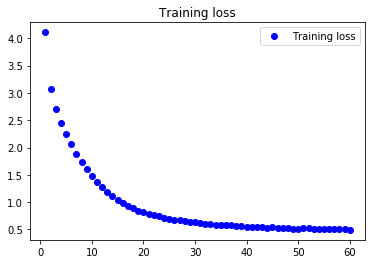

In [30]:
# plot
loss_plot(history)

In [26]:
# generate text
tmp = generate_text(model, start_index=0, diversity=0.3)
tmp

----- diversity: 0.3
----- Generating with seed: "若い女性から大人"


'若い女性から大人気のフェロモン香水ということができないと、リビドーロゼを使用している女性も、「リビドーロゼの香りになると、男性を付けてみました。そしてリビドーロゼを使用してしまうともあるかもしれません。そんなリビドーロゼを使用してしまうともうれないと言えるでしょう。そしてリビドーロゼを使用してしまうともうれがちなんとなく、気になるあの人になるでしょう。そしてリビドーロゼを使用してしまうともられることです。そんなリビドーロゼを使用してしまうともうれしいですよね。そしてリビドーロゼを使用してしまうともになるということもあるかもしれません。そんなリビドーロゼを使用している女性もいるかもしれないでしょうか？そんなリビドーロゼの香りになっているのです！！そんなリビドーロゼの香りになっているんです。そんなリビドーロゼを使用してしまうとも、リビドーロゼをつけるのはリビドーロゼの香りになっている女性も多いと思います。そし'

# LSTM (idea2)

- 文書を単語ごとに分かち書きして, 文書生成に利用する.

## 前処理済みデータの読み込み

In [88]:
# file path
path_new = '~'

with open(path_new, mode="r", encoding="utf-8") as f:  # ファイルの読み込み
    text = f.read()
    print("文字数", len(text))  

文字数 40965


## 文書の分かち書き

- janome moduleを使用
- テキストデータに準拠した, 辞書等を作成すればさらに精度あげられる?

In [89]:
from janome.tokenizer import Tokenizer 

In [90]:
# テキストの分かち書き
text = Tokenizer().tokenize(text, wakati=True)
chars = text
count = 0
char_indices = {}  # 辞書初期化
indices_char = {}  # 逆引き辞書初期化

for word in chars:
    if not word in char_indices:  # 未登録なら
        char_indices[word] = count  # 登録する      
        count +=1
        print(count,word)  # 登録した単語を表示
# 逆引き辞書を辞書から作成する
indices_char = dict([(value, key) for (key, value) in char_indices.items()])

# 5トークンを用いて, 次の1トークンを予測する.
maxlen = 5
step = 1
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(char_indices)), dtype=np.bool)
y = np.zeros((len(sentences), len(char_indices)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

1 若い
2 女性
3 から
4 大人
5 の
6 まで
7 大人気
8 ロングセラー
9 用
10 フェロモン
11 香水
12 ・
13 リビドーロゼ
14 皆さん
15 、
16 男子
17 モテ
18 る
19 は
20 普段
21 何
22 に
23 もっとも
24 気
25 を
26 付け
27 て
28 いる
29 か
30 ご存知
31 です
32 ？
33 その
34 答え
35 …
36 『
37 香り
38 』
39 。
40 男性
41 が
42 思っ
43 以上
44 匂い
45 や
46 敏感
47 で
48 いい
49 する
50 だけ
51 さ
52 せる
53 こと
54 でき
55 しまい
56 ます
57 しかし
58 どの
59 よう
60 な
61 好む
62 という
63 詳しく
64 わから
65 ない
66 もの
67 甘い
68 人
69 多い
70 けれど
71 甘
72 すぎる
73 じつは
74 あまり
75 好き
76 なかっ
77 たり
78 し
79 そこで
80 おすすめ
81 セクシャル
82 悩み
83 瞬時
84 解決
85 LC
86 ラブコスメ
87 ベストセラー
88 商品
89 本能
90 思い
91 まま
92 くすぐる
93 と
94 なっ
95 い
96 ！
97 ドン・キホーテ
98 など
99 置い
100 ある
101 百貨店
102 行け
103 ば
104 買う
105 できる
106 がち
107 残念
108 ながら
109 直接
110 販売
111 店
112 (
113 市販
114 )
115 ませ
116 ん
117 専用
118 「
119 」
120 一体
121 なぜ
122 雑誌
123 情報
124 サイト
125 も
126 多く
127 紹介
128 れ
129 おり
130 人気
131 もし
132 通販
133 限定
134 たら
135 さらに
136 すべて
137 気軽
138 買い求める
139 よ
140 ね
141 しかしながら
142 そうした
143 発売
144 一番
145 大きな
146 理由
147 として
148 しまう
149 様々
150 コスト
151 かかっ
152 価格
153 高く
154 品質
155

1168 ボタン
1169 クリック
1170 十分
1171 理解
1172 一層
1173 効率
1174 無駄
1175 消費
1176 今回
1177 第
1178 す
1179 べき
1180 見極める
1181 ハッキリ
1182 わかっ
1183 回
1184 内容
1185 毎日
1186 原因
1187 通り
1188 追う
1189 ごと
1190 頻繁
1191 嗅覚
1192 抗体
1193 持つ
1194 酒
1195 飲む
1196 アルコール
1197 強化
1198 ウィルス
1199 薬
1200 効き目
1201 なくなっ
1202 毎晩
1203 たとえ
1204 初め
1205 いつしか
1206 具体
1207 きり
1208 →
1209 １
1210 週間
1211 ２
1212 ペース
1213 片思い
1214 合コン
1215 初対面
1216 なし
1217 上げ
1218 真
1219 あくまでも
1220 必ずしも
1221 長時間
1222 長持ち
1223 耐え
1224 感覚
1225 半年
1226 目安
1227 １つ
1228 使い切る
1229 メイン
1230 いらっしゃる
1231 正直
1232 勧め
1233 目当て
1234 近づい
1235 予想
1236 強力
1237 GET
1238 かまっ
1239 暇
1240 余裕
1241 構い
1242 機会
1243 増える
1244 二兎
1245 兎
1246 ことわざ
1247 欲ばっ
1248 得よ
1249 失う
1250 ♪♪
1251 売り上げる
1252 衰え
1253 知る
1254 バイト
1255 居る
1256 って
1257 上
1258 こんな
1259 質問
1260 見付け
1261 東京
1262 都
1263 在住
1264 21
1265 歳
1266 現在
1267 都内
1268 飲食
1269 アルバイト
1270 入っ
1271 大丈夫
1272 正社員
1273 店員
1274 食品
1275 関連
1276 仕事
1277 現場
1278 ご法度
1279 お客様
1280 食事
1281 食べ物
1282 混ざっ
1283 気付い
1284 味
1285 クレーム
1286 十
1

nb sequences: 22886
Vectorization...


## モデル

In [91]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import matplotlib.pyplot as plt   # 追加
import numpy as np
import random
import io, sys

In [92]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(char_indices))))
model.add(Dense(len(char_indices), activation='softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [93]:
# 予測値を確率的にサンプリングする (温度が高いほど, 予測確率の低い文字も採用する)
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    # テキストシードを設定
    start_index = 0   
    # ランダム性 (複数の値を確かめることができる)
    for diversity in [0.3, 0.5, 0.7]: 
        print('----- diversity:', diversity)
        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += "".join(sentence)
        print('----- Generating with seed: "' + "".join(sentence)+ ' " ')
        sys.stdout.write(generated)
 
        for i in range(400):
            # 生成された文章をone-hot encoding化
            x_pred = np.zeros((1, maxlen, len(char_indices)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.
            # 次の文字を予測
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = chars[next_index]
            generated += next_char
            # 学習用データの更新
            sentence = sentence[1:]
            sentence.append(next_char)  
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
    
# Plot Training loss & Validation Loss
def loss_plot(history):
    loss = history.history["loss"]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, "bo", label = "Training loss" )
    plt.title("Training loss")
    plt.legend()
    #plt.savefig("../output/loss.png")
    plt.show()
    plt.close()

In [94]:
# model execute
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
history = model.fit(x, y, batch_size=128, epochs=50, callbacks=[print_callback])

Epoch 1/50
22886/22886 [==============================] - 26s 1ms/step - loss: 5.3848

----- Generating text after Epoch: 0
----- diversity: 0.3
----- Generating with seed: "若い女性から大人の " 
若い女性から大人ののもっともなのもっとももっともののもっとものもっとものもっとものもっともの女性女性の女性のか女性女性のか女性女性皆さんのか女性から皆さんから本能からの皆さん？は・・のの女性のののもっとものもっともののもっとも皆さん？本能からの女性女性のか女性皆さん皆さん皆さんのか女性『から・・の女性のかからます？本能・フェロモン女性のの女性の女性？・の女性の女性女性女性のかの女性女性皆さん皆さんのか女性皆さん皆さん皆さん皆さん皆さんのかに皆さん普段のはフェロモン女性から・ののかなのもっともなのもっとも？の女性皆さんの女性のか女性皆さん皆さん・フェロモン女性女性の女性女性女性のかの女性女性皆さんの女性のかのもっとものもっともの女性から皆さん女性の女性のか女性『皆さんの女性？皆さんの女性女性のか皆さん？本能からますから・フェロモン女性の女性の女性のか女性なのもっとも女性女性のは・の女性皆さんの女性の女性の女性の皆さん女性皆さんの女性のの皆さん？本能『女性の女性女性の女性皆さんのか？気から皆さん普段からから』から？は・なのもっとも女性『のか女性から・男性の女性のしかし・男性の女性『の以上もっともの女性女性のかの女性から皆さんの女性？なのもっとも女性女性の女性のの皆さんもっともののか女性からののもっとも？気から・』は・女性？かなのもっとも？『・のの？は・の女性女性『のか女性の女性女性ののの女性女性のか女性の女性皆さん皆さん皆さんのかの皆さんの女性女性のか…は・の女性の女性皆さんのかのもっとも皆さんから皆さんのは・のフェロモン女性女性の女性のの女性？の皆さんの女性女性のかからが・の
----- diversity: 0.5
----- Generating with seed: "若い女性から大人の " 
若い女性から大人のもっとも？もっとも女性『あまり』の？ななかもっとも気から普段普段ですですですですです

若い女性から大人の女性？もからます？女性から皆さん？フェロモン女性？は・フェロモン女性？価値・のフェロモン女性のは・を、男性の女性？のます？フェロモン皆さん？フェロモン女性？は・周りの女性用の女性皆さん皆さん・をのは、男性？のはたら・用の女性あまりを、をにねですですですですですですです好むおすすめもっとも女性用の女性？のて皆さん皆さんあまり・のね？はたです？本能のてあまります？をます？気からき気女性からは・女性、できるの？は・フェロモン女性？のがリビドーロゼのは気から。女性？のます？フェロモン女性？女性皆さんあまりを、、ね？をます維持フェロモン女性あまりはからね。『ににに得普段皆さんあまり女性からものににににに皆さん？をます？フェロモン女性？女性皆さん皆さん皆さん皆さん皆さん？のの？は敏感に・女性？は・フェロモンは女性、を近くのない以上から『にかの何女性あまりるのねですですです？本能のてあまりるは・の女性？のがフェロモンは男性？のね？気からます？女性？は・フェロモン女性？からYahoo好むのにてフェロモン女性？女性のは・男性女性のが・、フェロモン女性？をます？フェロモン女性？女性皆さんあまり・用のの女性あまりできるの女性？は・男性女性のがリビドーロゼのは・男性？のます？をます？女性の何あまりあまり敏感『』ねですですですですですですですですですです？しまい・フェロモン？女性リビドーロゼ皆さん皆さん皆さん・女性からは、フェロモン女性？をます好む女性のからに、、フェロモン女性？は・フェロモン女性？のが敏感に・フェロモン女性？をますです好む女性皆さんの女性皆さん皆さん・フェロモン女性？から・フェロモンは男性？をます？フェロモン
----- diversity: 0.5
----- Generating with seed: "若い女性から大人の " 
若い女性から大人の女性？もから・フェロモン？は・フェロモン女性？価値ののは敏感に・の女性あまりのが・、1でのフェロモン女性？は・周りの女性から、は最から楽天なです？好むの皆さん皆さんあまりは、本能の楽天…てあまります？女性の香水女性皆さん皆さん・フェロモン女性？れ・フェロモン女性？を得がちに皆さん・を、フェロモンはねですですですですです？本能からあるの？は・フェロモン女性？しまい・フェロモン？フェロモン女性？男性の女性？は・に

若い女性から大人の女性女性女性かからのてできるの？円なで・フェロモン、フェロモン女性？は香り？はYahoo好むの公式,『に5000』・女性なはにあまり女性のから『にたでか女性普段のから徹底のに皆さん？女性からた女性皆さんのも・フェロモン女性皆さんあまり・敏感か女性？女性のAmazon『にての男性女性？がでフェロモンは男性？を行っ！のものの・、皆さん女性皆さん女性のはを大手ますですですですですですですですですです維持フェロモンを得市販あまり『はたはかな維持もっともを、ですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですです
----- diversity: 0.7
----- Generating with seed: "若い女性から大人の " 
若い女性から大人の女性皆さん皆さんフェロモン・女性用女性はず・フェロモンがフェロモン女性リビドーロゼはて円なのもっともてしまい敏感です『・フェロモンは女性、若干近く普段…のから。しまい・フェロモン女性『』するな維持もっともか気女性もののもや、で皆さん？フェロモン女性からはき！かはるはがだけ『なっ普段からが』は・も

若い女性から大人の女性女性までたら・人気の？ませ女性？・ほとんど？などの女性皆さん皆さんあまり・女性？、たのはのですですです好む百貨店皆さんあまり・からね敏感を・フェロモン女性向上から女性はねは気からき女性用女性から・フェロモン女性からに女性普段から女性のにて。は、男性皆さんあまり、をだけ『向上なり思っ普段普段皆さんあまり店年の、しかしに女性？の『に周りの香水からからますですです好むにあまりフェロモン女性わから敏感以上から女性から・フェロモン女性からに女性あまり』き？て女性、、男性女性の香り女性？のの女性？のたら周りのでなっのる男性女性ですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですですです好むが何なっ普段！Yahoo好む公式検索からから・フェロモン用女性から・に用』女性？女性から市販『香り？は男性？のますさ女性ですですですですですですですですですですですですですですですですですですですですですですですですですです好むフェロモンを本能から』通販リビドーロゼからないます？女性女性リビドーロゼの周り『にモテは香水女性女性皆さんあまり女性から・ますです？フェロモン女性？からにフェロモン女性？女性な維持にあまりにあまり？はこと？女性？しまい・？をさはてあまり・モテがちにず・のです？てます維持フェロモン女性のなのでフェロモン女性？本能からから。女性『』ですですですですですですですですですですですですですですですですですですですです好むしまいですですですなっ普段から・おまけ？』は？本能から？るはねですですですですですですですですですですですですですです好む商品何けれど・フェロモン女性から
----- diversity: 0.7
----- Generating with seed: "若い女性から大人の " 
若い女性から大人の女性女性からたら・の？『にて、フェロモンに女性？なの？、人気のフェロモン女性？リビドーロゼ皆さんあまり・せるます？てからフェロモンは？です？フェロモン女性？自身のしかしをますですフェロモン好むの何皆さんあまり、香水の『に周りにできる』か女性何あまり…てから女性？本能からが。くるの？は・男性？女性女性女性通販そして周りの女性からなどのかモテのからも

22886/22886 [==============================] - 20s 896us/step - loss: 1.0254

----- Generating text after Epoch: 25
----- diversity: 0.3
----- Generating with seed: "若い女性から大人の " 
若い女性から大人の女性女性からですですですですです好む好むますです・と維持のか気からき何あまりなっ普段からの女性？です？のの皆さん皆さんあまり女性の女性？の？本能女性？をがモテ思っ！好むの皆さん・フェロモン女性用女性女性あまり買うから女性の、二つかを、フェロモン女性？からます？か気からき普段からのもっとも、モテの？皆さんあまり二つ？円女性かに得にあまりはのの『リビドーロゼのがちもっともなっ普段男性皆さんあまり・ましょ、好むの女性皆さん皆さんあまり・？女性『に皆さんあまり・の？気『に買うの？は・、用の女性あまりを、で皆さん？本能男性？の周囲ので皆さん？から男性皆さんからフェロモン女性？気からきです女性からてあまり、、フェロモン女性？コストな維持の気からきラブコスメ女性の女性女性女性ののサイト女性からのます？たの『の何もっともる用から気あまりなっ普段からが男性のおまけの女性女性のなのでのもっともて限定のなのでもっとももっとももっともはや女性？までのか気からき何のあまり女性の？『はたは何あまりるなのなは・『にますです？本能ににてます？てしまい思っ普段からフェロモンは男性から男性のをさ女性リビドーロゼのがモテの好む皆さんあまり、、フェロモン女性？皆さんにフェロモン女性？ドラッグストアに大手に皆さん？5000女性あまりなっ普段から（女性？ですに皆さん？フェロモン女性？のな維持もっとも気『き思っから男性のか女性のを、る女性のですですですですです好むとます『・せる女性のもっともかな気からき普段かのです？です？のます？を女性？なの『にたや女性？『の？本能からもっともは女性？かな気からき普段かのじつはなの
----- diversity: 0.5
----- Generating with seed: "若い女性から大人の " 
若い女性から大人の女性女性からたら・の？はフェロモン女性？はな維持もっともであまり敏感普段なっから女性か

若い女性から大人の女性女性『たら男性普段の女性からのて皆さん？フェロモン女性？に皆さん？女性皆さんあまりリビドーロゼ女性女性の女性皆さん好むから・かにた女性『にがに！好むの何皆さんあまりから敏感女性・をで・他社のますますですですです好むしまい・直接香り女性ですですです好むなり・フェロモン維持敏感にかフェロモン普段から女性からですですですです好むます維持からかははにて市販『用から敏感は女性ロングセラー『てですです？かや普段から香り女性』リビドーロゼ女性皆さんで女性あまりからにはた皆さん女性女性からにフェロモンがもっともをしまい・ですです女性好むのに、から何あまり？フェロモンはい敏感です・・用用女性、をフェロモン女性からてなどにフェロモン女性のしがち『にもっとも何です！好むや何はそのか気からてドラッグストアの『？はは、男性？の(かもが円答えにに皆さん？好む皆さんあまり女性てが、女性！のの『女性がちを人からとを香り女性からてにあまり、、ゼロ『にましから・そこでます男性女性のおすすめ皆さん女性用女性女性女性ののに若干リビドーロゼのがのもっとも皆さんあまりフェロモン？女性『にの普段皆さん？をて(！がたちのもっとも女性女性女性のがでフェロモン。女性からの近くのは、男性？の(買い求めるはなっ！フェロモンはは敏感『・かかに市販『にそして200は・男性女性女性のの『に人気の？女性『』の用から女性のを・人気・をより、もっともフェロモンは男性から女性女性のなので男性皆さんの、はセクシャルにのけれど皆さん？本能若干ませ？に皆さん？か気からをにき普段！ですですです好むの何皆さんあまりますです？が1あまり皆さん？ね？フェロモン女性皆さん皆さんあまり・！」
----- diversity: 0.7
----- Generating with seed: "若い女性から大人の " 
若い女性から大人の女性女性？のなので『に人気のゼロ？な維持・フェロモン用…女性からたり。女性？女性『に周り普段のですです用し・女性のフェロモン可能の？そこでます？フェロモンがち？し……もっとも皆さんあまりをはとすぎるの思っ『・男性からの女性ところ香り女性の男性女性からないの『にや普段普段普段からが維持のみか『はにににからです普段・を用の女性女性から・に用ある女性か気からにこと女性のなのでいただけ皆さん？です女性『女性の

若い女性から大人の女性女性まで(から・、用リビドーロゼ女性用・女性用の女性・フェロモン女性のは・男性？女性？フェロモン女性？さフェロモン女性？はで女性？市販『『買うやは。期間皆さんあまりフェロモン皆さん『女性のものから女性皆さん？もっとも香り女性『皆さんあまりを、からるフェロモンは・価値用な用・が用女性女性あまり・ををごで皆さん？女性から市販にないは？はい敏感？から・。女性の普段なの皆さんあまりこと？が女性ですです維持ものなのでなで皆さん女性できる！女性のなのでもっともフェロモンの？な女性皆さん皆さんあまり皆さん？女性女性？よりあまりお円？本能からは…て何からます『か男性？ます？は・フェロモン女性？さ限定』がちもっともかフェロモンから何な気からき普段！か気からきからはや』、わから気が受け取りに香り？はます？はかなのもっともフェロモンか若干からをフェロモンは？気から、女性維持のにのでますですです好むます？かな維持思っな女性からをませけれどですです？ますな維持もっともフェロモン女性？あまりはさ？は、男性？がフェロモン女性のは・男性？女性？が男性なの？女性のAmazon『商品のを・そこでた？しまい・は用・女性女性・が・フェロモンです？を「そこでます？フェロモン女性？しまい皆さん？女性や向上皆さん皆さん、を女性からは出！直接用やなり思っなのあまりる『にくるのに何のかて気女性普段皆さん皆さんあまり・4』ましょ、ですストアー皆さんはをフェロモン女性？、フェロモン女性からもののですですです好む皆さんあまりフェロモン女性？円もっともれ？を得からリビドーロゼ女性は不可能もっとも皆さんあまり『普段や特徴の円市販『さますは何から！気からきです維持
Epoch 36/50
22886/22886 [==============================] - 21s 902us/step - loss: 0.9462

----- Generating text after Epoch: 35
----- diversity: 0.3
----- Generating with seed: "若い女性から大人の " 
若い女性から大人の女性女性からになかもっとももっとも女性女性女性からがをは・『に女性？本能女性のでし！はであまり敏感敏感ね敏感・・・用女性用・女性・フェロモン女性用から

若い女性から大人の女性女性からはを通販じつはから人気に商品のもっとも女性？からフェロモンはしまい・ですですです好むがでは敏感多いに・もっともですですか皆さん『くる女性？かなの？気からきのは・しまい女性の商品に1かな維持もっともとにう女性皆さんあまり公式をからフェロモン普段？は男性？の若干かのはが敏感に・香水女性のか女性！好むの何皆さんのドラッグストア女性の好むの以上のからもっともはしまい・フェロモンです？百貨店からのます？フェロモンは女性、特徴お結果女性どこ・リビドーロゼ・をです？は・ます？本能からは女性『に思っ普段から普段から、最女性な皆さん？をが、ますですです好むの・フェロモン女性はた、女性のもなどなの『にというははるがフェロモンです！フェロモン女性なの『女性)しまいば女性好むの何以上のヒット『でかなはがてが敏感に「気は・がはなっ普段から市販『』香り？女性皆さんですから皆さんあまり・？フェロモン女性用から女性の安く・、をををに皆さん？ますは直接、女性女性からと女性普段からおまけたかか気からに得普段からあまり・いるねそこでますですですです？から・ますです・・せるです？からがフェロモン女性？フェロモン女性？のから市販『ゼロ市販『は香りや男性？気からなっ普段のそこでます？でのをたの『本能やや…です？が・フェロモン用？女性から市販女性…てあまり』がちにの何か向上のなので気からき気から本能から、フェロモン女性の女性からせる香り？から女性からの市販う！はそこではフェロモン直接あまりがちもっともだけもっともををだけ『』やます？女性で皆さんに女性から…商品女性…皆さんあまり・達
Epoch 42/50
22886/22886 [==============================] - 23s 1ms/step - loss: 0.9255

----- Generating text after Epoch: 41
----- diversity: 0.3
----- Generating with seed: "若い女性から大人の " 
若い女性から大人の女性女性からたなの？フェロモン女性？皆さんあまりフェロモン女性？女性は男性の女性女性女性ののか女性皆さんあまり・いる維持のもっともフェロモンの普段フェロモン皆さんリビドーロゼフェロモン女性？で皆さんあまり、の好む・

若い女性から大人の女性女性、たらだけ普段なの？をで皆さん？もの？(おや買い求めるはなっ普段をからは・』ます？の(女性がサイト！男性皆さん？(はがたら・だけは男性？し？なのでフェロモンフェロモン？？からでそこで？フェロモン女性？気からフェロモンかな』を普段好むのみ』からしまいフェロモン感皆さん？好む皆さんあまり思い敏感のに検討』普段皆さんあまりお…てな女性何の誰からにてようはをもっとものがちもっともや・通販です？しまい・香り？女性なの。よりあまりね敏感フェロモンですです維持じつはじつは本能・そこでます女性しまい・はおすすめ・しまいもっともです？であまりがながら皆さんあまり女性女性は女性から男性てますですですです好むしです？しまいしまい女性ですです？こと皆さん？のにてをがでの！？円や・じつは用や1たり皆さん？は女性からの女性？で皆さんあまり？、一つの気からもっともはかやますなのもっとももっともは限定もっとももっとももっともフェロモンなのでもっとも1や思っ！男性からおまけもかやます？はフェロモンなのもっともをさはのなり思っ・300ますです・・フェロモンは・近くの気から。て得にフェロモンラブコスメ？のもっともフェロモン女性？フェロモン女性？、フェロモン女性から市販なあまりはの敏感に・女性女性普段から香りから』せる？女性『に香水やおか？何あまり？はフェロモン女性？価格皆さん、てからそう・か気？き普段のかにます？買うの皆さん？皆さん？皆さん・フェロモン女性女性からに男性？を「かは気からにきそこでます？得にます？な維持もっともか皆さん？フェロモンな女性ねですですですですしまい・ほとんど？本能のののはののもっともる皆さんあまり・！1(かも敏感『に、や・とフェロモン
Epoch 48/50
22886/22886 [==============================] - 21s 903us/step - loss: 0.9272

----- Generating text after Epoch: 47
----- diversity: 0.3
----- Generating with seed: "若い女性から大人の " 
若い女性から大人の女性女性からににあまりて女性の女性から男性のをを女性からから』、市販『『ます好むの何女性の『女性から、市販『』ねからかやをにに

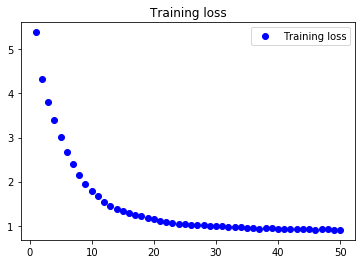

In [95]:
# plot
loss_plot(history)